In [1]:
#Madeline Olson + Luca Kader

In [2]:
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

In [3]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/08 21:39:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#Q1: how many banks contain the word "first" in their name, ignoring case? Use an RDD to answer.
banks_df = spark.read.option("header", "true").option("inferSchema", "true") \
.csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv") 

banks_rdd = banks_df.rdd

banks_rdd.filter(lambda row: "first" in row.respondent_name.lower()).count()

525

In [5]:
#Q2: how many banks contain the word "first" in their name, ignoring case? Use a DataFrame to answer.
banks_df.filter("LOWER(respondent_name) LIKE '%first%'").count()

525

In [6]:
#Q3: how many banks contain the word "first" in their name, ignoring case? Use Spark SQL to answer.
banks_df.write.saveAsTable("banks", mode="overwrite")
spark.sql("""
SELECT COUNT(*) as first_count
FROM banks
WHERE LOWER(respondent_name) LIKE "%first%"
            """).collect()[0]['first_count']

23/11/08 21:40:33 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/08 21:40:33 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/11/08 21:40:42 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/11/08 21:40:42 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.24.0.3
23/11/08 21:40:43 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/11/08 21:40:52 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
23/11/08 21:40:52 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
23/11/08 21:40:52 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/08 21:40:52 W

525

In [7]:
#Q4: what tables are in our warehouse?
loans_df = spark.read.option("header", "true").option("inferSchema", "true") \
.csv("hdfs://nn:9000/hdma-wi-2021.csv")

loans_df.write.bucketBy(8, "county_code").saveAsTable("loans", mode="overwrite")

datasets = [
    "ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken",
    "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"
]

for dataset in datasets:
    df = spark.read.option("header", "true").option("inferSchema", "true") \
    .csv(f"hdfs://nn:9000/{dataset}.csv")
    df.createOrReplaceTempView(dataset)

#spark.sql("SHOW TABLES").show()

tables_df = spark.sql("SHOW TABLES")
tables_list = tables_df.collect()
tables_dict = {row.tableName: row.isTemporary for row in tables_list}
tables_dict


23/11/08 21:41:24 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [8]:
#Q5: how many loan applications has the bank "University of Wisconsin Credit Union" received in 2020 in this dataset?
spark.sql("""
SELECT COUNT(*)
FROM banks
INNER JOIN loans ON banks.lei_2020 = loans.lei
WHERE respondent_name = "University of Wisconsin Credit Union"
""").toPandas()['count(1)'][0]

19739

In [9]:
#Q6: what does .explain("formatted") tell us about how Spark executes Q5?
spark.sql("""
SELECT COUNT(*)
FROM banks
INNER JOIN loans ON banks.lei_2020 = loans.lei
WHERE respondent_name = "University of Wisconsin Credit Union"
""").explain("formatted")

# 1. Which Table is sent to every executor via a BroadcastExchange operation?
    # Table lei_2020#70 from the banks module, since banks has reference lei_2020.
# 2. Does the plan involve HashAggregates. If so, which ones?
    # Yes——HashAggregate (11) and HashAggregate (9)
    # HashAggregate 9 is a partial count, whereas HashAggregate 11 is 

== Physical Plan ==
AdaptiveSparkPlan (12)
+- HashAggregate (11)
   +- Exchange (10)
      +- HashAggregate (9)
         +- Project (8)
            +- BroadcastHashJoin Inner BuildLeft (7)
               :- BroadcastExchange (4)
               :  +- Project (3)
               :     +- Filter (2)
               :        +- Scan parquet spark_catalog.default.banks (1)
               +- Filter (6)
                  +- Scan parquet spark_catalog.default.loans (5)


(1) Scan parquet spark_catalog.default.banks
Output [2]: [respondent_name#66, lei_2020#70]
Batched: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/banks]
PushedFilters: [IsNotNull(respondent_name), EqualTo(respondent_name,University of Wisconsin Credit Union), IsNotNull(lei_2020)]
ReadSchema: struct<respondent_name:string,lei_2020:string>

(2) Filter
Input [2]: [respondent_name#66, lei_2020#70]
Condition : ((isnotnull(respondent_name#66) AND (respondent_name#66 = University of Wisconsin Credit Union)) AND i

In [10]:
#Q7: what are the average interest rates for Wells Fargo applications for the ten countries where Wells Fargo receives the most applications?
avg_int = spark.sql("""
SELECT NAME, AVG(interest_rate) AS avg, respondent_name, COUNT(*) AS num_applications
FROM loans
JOIN banks ON loans.lei = banks.lei_2020
JOIN counties ON loans.county_code = counties.STATE*1000 + counties.COUNTY 
WHERE respondent_name = "Wells Fargo Bank, National Association"
GROUP BY NAME, respondent_name
ORDER BY num_applications DESC
LIMIT 10
""").toPandas()

q7_dict = {}
for i in range(len(avg_int)):
    q7_dict[avg_int['NAME'][i]] = avg_int['avg'][i]
q7_dict

{'Milwaukee': 3.1173465727097907,
 'Waukesha': 2.8758225602027756,
 'Washington': 2.851009389671362,
 'Dane': 2.890674955595027,
 'Brown': 3.010949119373777,
 'Racine': 3.099783715012723,
 'Outagamie': 2.979661835748792,
 'Winnebago': 3.0284761904761908,
 'Ozaukee': 2.8673765432098772,
 'Sheboygan': 2.995511111111111}

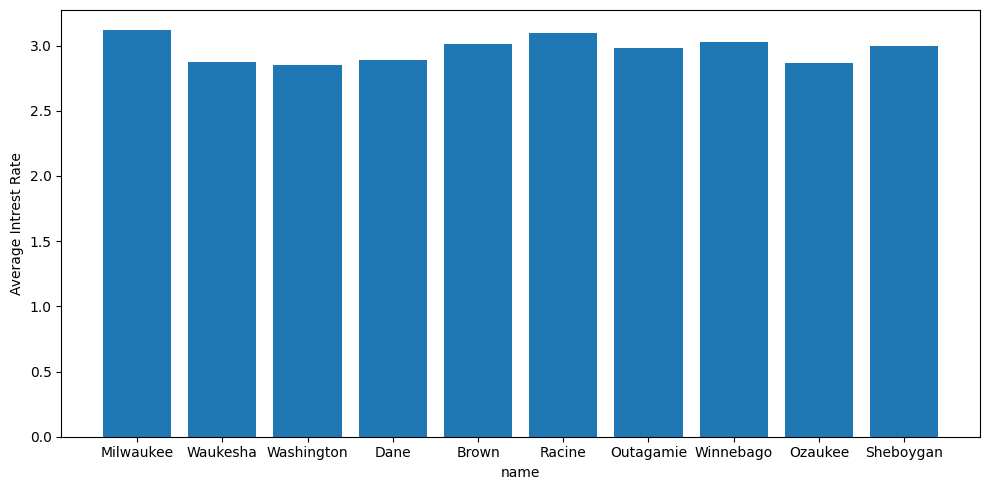

In [11]:
from matplotlib import pyplot as plt
keys = list(q7_dict.keys())
values = list(q7_dict.values())
plt.figure(figsize=(10, 5)) 
plt.bar(keys, values)
plt.xlabel('name')
plt.ylabel('Average Intrest Rate')
plt.tight_layout()
plt.show()

In [12]:
#Q8: when computing a MEAN aggregate per group of loans, under what situation (when) do we require network I/O between the partial_mean and mean operations?
spark.sql("""
SELECT county_code, AVG(interest_rate) as avg
FROM loans
GROUP BY county_code
""").explain("formatted")

# The query plan for county_code does not indicate any exchange operation. Therefore, it does not require netork I/O between partial and mean operations. 
# The data is partitioned and grouped efficiently by county_code, and there is no need for I/O.

spark.sql("""
SELECT lei, AVG(interest_rate) as avg
FROM loans
GROUP BY lei
""").explain("formatted")

# The execution plan for lei does include an exchance operation. That means that in order for the partial mean results from different tasks to be combined, 
# there must be network I/O between the operations. The data is not efficiently grouped by lei.

== Physical Plan ==
AdaptiveSparkPlan (4)
+- HashAggregate (3)
   +- HashAggregate (2)
      +- Scan parquet spark_catalog.default.loans (1)


(1) Scan parquet spark_catalog.default.loans
Output [2]: [county_code#991, interest_rate#1010]
Batched: true
Bucketed: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/loans]
ReadSchema: struct<county_code:string,interest_rate:string>
SelectedBucketsCount: 8 out of 8

(2) HashAggregate
Input [2]: [county_code#991, interest_rate#1010]
Keys [1]: [county_code#991]
Functions [1]: [partial_avg(cast(interest_rate#1010 as double))]
Aggregate Attributes [2]: [sum#1123, count#1124L]
Results [3]: [county_code#991, sum#1125, count#1126L]

(3) HashAggregate
Input [3]: [county_code#991, sum#1125, count#1126L]
Keys [1]: [county_code#991]
Functions [1]: [avg(cast(interest_rate#1010 as double))]
Aggregate Attributes [1]: [avg(cast(interest_rate#1010 as double))#1120]
Results [2]: [county_code#991, avg(cast(interest_rate#1010 as double))#1120

In [13]:
#Q9
from pyspark.sql.functions import col
from pyspark.sql import functions as F

df = spark.sql("""
SELECT l.loan_amount, l.income, l.interest_rate, a.action_taken
FROM loans l
JOIN action_taken a ON l.action_taken = a.id
""")

df = df.withColumn("income", col("income").cast("double"))
df = df.withColumn("interest_rate", col("interest_rate").cast("double"))
df = df.na.fill(0.0)
df = df.withColumn("approval", F.when(df["action_taken"] == "Loan originated", 1.0).otherwise(0.0))

train, test = df.randomSplit([0.8, 0.2], seed=41)

approved_loans_count = train.filter(col('approval') == 1.0).count()
approved_loans_count

242941

In [14]:
#Q10: what is the accuracy of the decision tree classifier of depth 5 on the test dataset?
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.pipeline import Pipeline, Pipeline, Model
va  = VectorAssembler(inputCols=["loan_amount", "income", "interest_rate"], outputCol="features")
dt = DecisionTreeClassifier(featuresCol="features", labelCol = "approval", maxDepth=5)

model = dt.fit(va.transform(train))

test_data = va.transform(test)
predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="approval", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

accuracy

0.8911497233940716